<a href="https://colab.research.google.com/github/SnSabu/Machine-Learning-Projects/blob/main/PA_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Predicting Wine Prices using Neural Networks


> By Sneha Sabu



The dataset used in this analysis is from Kaggle: https://www.kaggle.com/datasets/dev7halo/wine-information

In [ ]:
#!pip install nnv
#! pip install fancyimpute

In [19]:
#Importing necessary Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
from numpy import mean
from numpy import std
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
from nnv import NNV
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

In [131]:
WineData = pd.read_csv("/content/cleansingWine.csv")

<ipython-input-131-459e905232e6>:1: DtypeWarning: Columns (8,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  WineData = pd.read_csv("/content/cleansingWine.csv")


### Data Exploration and Preprocessing

In [132]:
WineData.head()

,Unnamed: 0,id,name,producer,nation,local1,local2,local3,local4,varieties1,...,use,abv,degree,sweet,acidity,body,tannin,price,year,ml
0,0,137197,Altair,Altair,Chile,Rapel Valley,NaN,NaN,NaN,Cabernet Sauvignon,...,Table,14~15,17~19,SWEET1,ACIDITY4,BODY5,TANNIN4,220000,2014,750
1,1,137198,"Altair, Sideral",Altair,Chile,Rapel Valley,NaN,NaN,NaN,Cabernet Sauvignon,...,Table,14~15,16~18,SWEET1,ACIDITY3,BODY4,TANNIN4,110000,2016,750
2,2,137199,Baron du Val Red,Baron du Val,France,NaN,NaN,NaN,NaN,Carignan,...,Table,11~12,15~17,SWEET2,ACIDITY3,BODY2,TANNIN2,0,0,750
3,3,137200,Baron du Val White,Baron du Val,France,NaN,NaN,NaN,NaN,Carignan,...,Table,11~12,9~11,SWEET1,ACIDITY3,BODY2,TANNIN1,0,0,750
4,4,137201,"Benziger, Cabernet Sauvignon",Benziger,USA,California,NaN,NaN,NaN,Cabernet Sauvignon,...,Table,13~14,17~19,SWEET1,ACIDITY3,BODY3,TANNIN4,0,2003,750


In [133]:
# Preprocessing abv and degree data
WineData['abv2'] = WineData['abv'].str.split('~')
WineData['abv_first'] = WineData['abv2'].apply(lambda x: x[0] if isinstance(x, list) and not pd.isna(x[0]) else 0)
WineData['abv_second'] = WineData['abv2'].apply(lambda x: x[1] if isinstance(x, list) and len(x) >= 2 and not pd.isna(x[0]) else 0)
WineData['abv_mean'] = (WineData['abv_first'].astype(float) + WineData['abv_second'].astype(float)) / 2
WineData.drop(['abv', 'abv2', 'abv_first', 'abv_second'], axis=1, inplace=True)

WineData['degree2'] = WineData['degree'].str.split('~')
WineData['degree_first'] = WineData['degree2'].apply(lambda x: x[0] if isinstance(x, list) and not pd.isna(x[0]) else 0)
WineData['degree_second'] = WineData['degree2'].apply(lambda x: x[1] if isinstance(x, list) and len(x) >= 2 and not pd.isna(x[0]) else 0)
WineData['degree_mean'] = (WineData['degree_first'].astype(float) + WineData['degree_second'].astype(float)) / 2
WineData.drop(['degree', 'degree2', 'degree_first', 'degree_second'], axis=1, inplace=True)


In [134]:
# Replace all 0's with NaN
WineData = WineData.replace(0, np.nan)
null_percentages = (WineData.isna().sum() / len(WineData)) * 100
print(null_percentages)

Unnamed: 0      0.004629
id              0.000000
name            0.000000
producer        0.000000
nation          0.009257
local1          4.165702
local2         48.414719
local3         83.378847
local4         99.990743
varieties1      1.615367
varieties2     65.202499
varieties3     81.356168
varieties4     93.844018
varieties5     98.245776
varieties6     99.514001
varieties7     99.856515
varieties8     99.916686
varieties9     99.967600
varieties10    99.972229
varieties11    99.976857
varieties12    99.981486
type            0.268456
use             0.064800
sweet           0.009257
acidity         0.060171
body            0.060171
tannin          0.060171
price          42.087480
year           12.038880
ml              0.620227
abv_mean       33.080305
degree_mean    33.071048
dtype: float64


In [135]:
# Dropping columns with more than 45% NAs
WineData = WineData.drop(null_percentages[null_percentages > 45].index, axis=1)

In [136]:
# Dropping the columns which will not be useful for modelling
WineData.drop(['Unnamed: 0','id', 'name'], axis=1, inplace=True)

In [137]:
# Drop rows where price in NA
WineData = WineData.dropna(subset=["price"])

In [138]:
(WineData.isna().sum() / len(WineData)) * 100

producer        0.000000
nation          0.000000
local1          3.724425
varieties1      1.326726
type            0.191816
use             0.055946
sweet           0.015985
acidity         0.000000
body            0.000000
tannin          0.000000
price           0.000000
year           11.532928
ml              0.487532
abv_mean       32.416880
degree_mean    32.416880
dtype: float64

In [ ]:
# Using KNN to impute the missing values for numerical values
from fancyimpute import KNN
numeric_cols = WineData.select_dtypes(include=[np.number]).columns.tolist()
WineData[numeric_cols] = KNN(k=5).fit_transform(WineData[numeric_cols])


In [140]:
WineData.describe()

,price,year,ml,abv_mean,degree_mean
count,1.251200e+04,12512.000000,12512.000000,12512.000000,12512.000000
mean,1.600060e+05,2012.338034,746.486493,9.020278,13.646897
std,3.146727e+05,4.813670,134.106947,3.301306,3.718590
min,3.900000e+03,1976.000000,100.000000,1.000000,3.000000
25%,4.000000e+04,2009.000000,750.000000,6.500000,11.000000
50%,7.400000e+04,2013.000000,750.000000,7.250000,15.000000
75%,1.600000e+05,2016.000000,750.000000,12.500000,17.000000
max,8.000000e+06,2020.000000,6000.000000,35.000000,75.000000


### Data Visualization

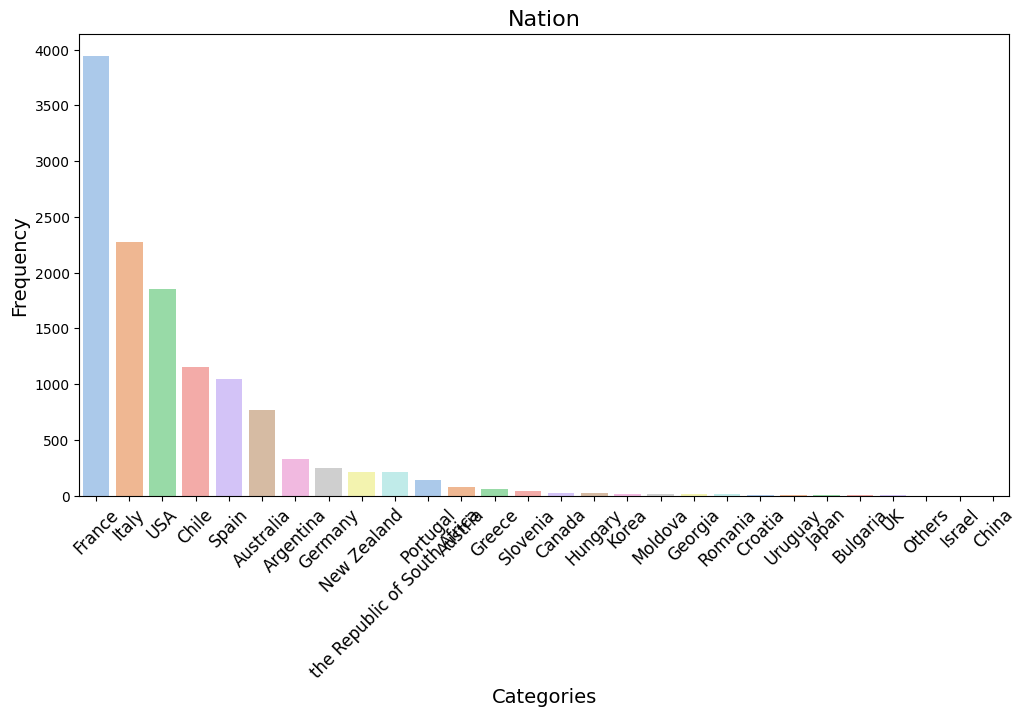

In [141]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
order = WineData['nation'].value_counts().index
sns.countplot(x='nation', data=WineData, palette='pastel', order=order)
plt.title('Nation', fontsize=16)
plt.xlabel('Categories', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.show()


Top three countries of origin of these wines are France, Italy and USA

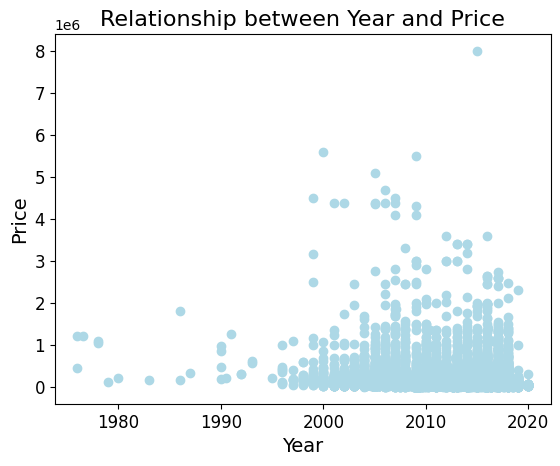

In [102]:
import matplotlib.pyplot as plt

plt.scatter(WineData['year'], WineData['price'], color='lightblue')
plt.title('Relationship between Year and Price', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()



The recent year wines seem to be more expencsive than older wines

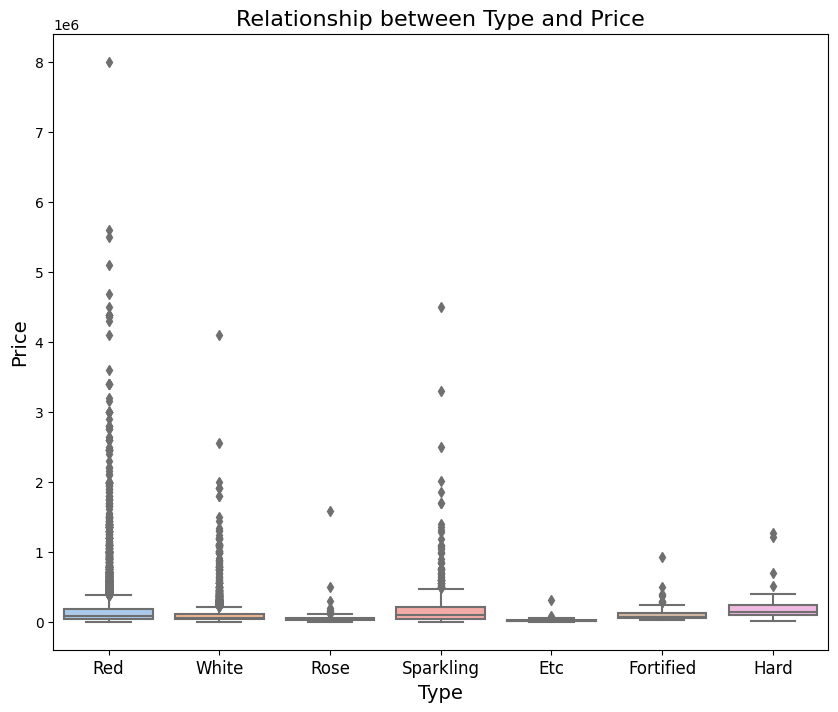

In [104]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.boxplot(x='type', y='price', data=WineData, palette='pastel')
plt.title('Relationship between Type and Price', fontsize=16)
plt.xlabel('Type', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.xticks(fontsize=12)
plt.show()


Even though the median values of the price of different wine types seem to be similar, Red Wine have a lot of outliers.

### Modeling using Neural Networks

In [ ]:
#Converting categorical data to dummmies
from sklearn.preprocessing import LabelEncoder
for label in WineData.columns:
    WineData[label] = LabelEncoder().fit(WineData[label]).transform(WineData[label])


Next, I will be trying out different parameters of Neural Networks to see the differences in outputs.

In [108]:
# Separate input features and target variable
X = WineData.drop(['price'], axis=1)
y = WineData['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# NN Model1
regr = MLPRegressor(solver='adam', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=10, max_iter=500)
regr.fit(X_train, y_train)

# Make predictions on the training and test sets
y_train_pred = regr.predict(X_train)
y_test_pred = regr.predict(X_test)

# Compute R2 score on the training and test sets
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Report performance
print('Training R2 score: {:.2f}'.format(r2_train))
print('Test R2 score: {:.2f}'.format(r2_test))

Training R2 score: 0.38
Test R2 score: 0.40


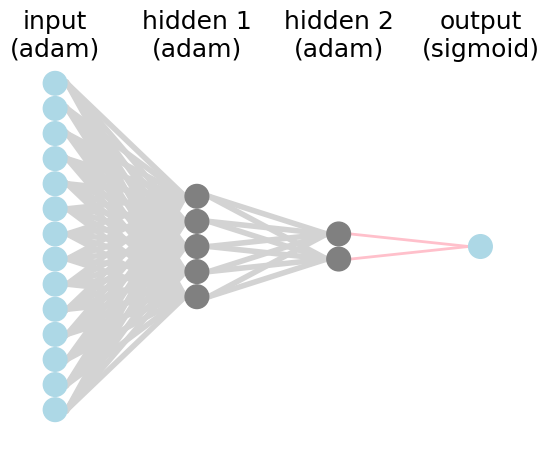

(<Figure size 2000x500 with 1 Axes>, <Axes: >)

In [114]:
plt.rcParams["figure.figsize"] = (20, 5)

layers_list = [    
    {"title":"input\n(adam)", "units": X_train.shape[1], "color": "lightblue"},    
    {"title":"hidden 1\n(adam)", "units": 5},    
    {"title":"hidden 2\n(adam)", "units": 2, "edges_color":"pink", "edges_width":2},    
    {"title":"output\n(sigmoid)", "units": 1,"color": "lightblue"},]

NNV(layers_list, max_num_nodes_visible=14, node_radius=8, spacing_layer=80).render()

In [124]:

# NN model 2
regr = MLPRegressor(solver='adam', alpha=1e-5, hidden_layer_sizes=(20, 10), random_state=50, max_iter=1000)

regr.fit(X_train, y_train)

y_train_pred = regr.predict(X_train)
y_test_pred = regr.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print('Training R2 score: {:.2f}'.format(r2_train))
print('Test R2 score: {:.2f}'.format(r2_test))

Training R2 score: 0.40
Test R2 score: 0.40


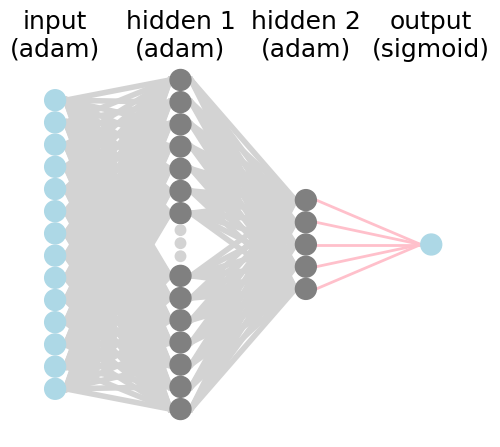

(<Figure size 2000x500 with 1 Axes>, <Axes: >)

In [153]:
# neural network figure
plt.rcParams["figure.figsize"] = (20, 5)

layers_list = [    
    {"title":"input\n(adam)", "units": X_train.shape[1], "color": "lightblue"},    
    {"title":"hidden 1\n(adam)", "units": 20},    
    {"title":"hidden 2\n(adam)", "units": 5, "edges_color":"pink", "edges_width":2},    
    {"title":"output\n(sigmoid)", "units": 1,"color": "lightblue"},]

NNV(layers_list, max_num_nodes_visible=14, node_radius=8, spacing_layer=80).render()


The two MLPRegressor models using Adam Solver have similar performance on the test set, with R2 scores of 0.40. The first model has two hidden layers with 5 and 2 units, while the second model has two hidden layers with 20 and 10 units. This suggests that the second model may have more capacity to learn complex patterns in the data. 

In [120]:
# Create MLP model
regr = MLPRegressor(solver='sgd', alpha=0.0001, hidden_layer_sizes=(15, 5), random_state=0, max_iter=1000)

# Train MLP model on training set
regr.fit(X_train, y_train)

# Make predictions on the training and test sets
y_train_pred = regr.predict(X_train)
y_test_pred = regr.predict(X_test)

# Compute R2 score on the training and test sets
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Report performance
print('Training R2 score: {:.2f}'.format(r2_train))
print('Test R2 score: {:.2f}'.format(r2_test))

Training R2 score: -476541.01
Test R2 score: -483893.69


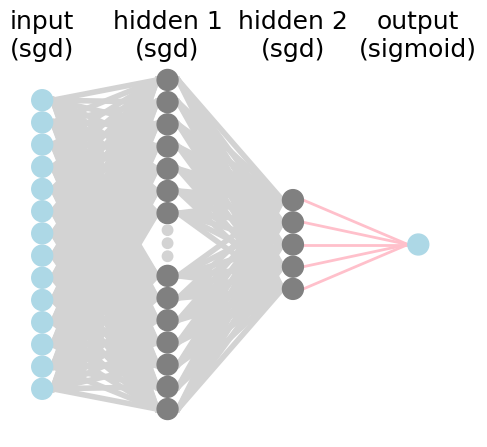

(<Figure size 2000x500 with 1 Axes>, <Axes: >)

In [155]:
# neural network figure
plt.rcParams["figure.figsize"] = (20, 5)

layers_list = [    
    {"title":"input\n(sgd)", "units": X_train.shape[1], "color": "lightblue"},    
    {"title":"hidden 1\n(sgd)", "units": 15},    
    {"title":"hidden 2\n(sgd)", "units": 5, "edges_color":"pink", "edges_width":2},    
    {"title":"output\n(sigmoid)", "units": 1,"color": "lightblue"},]

NNV(layers_list, max_num_nodes_visible=14, node_radius=8, spacing_layer=80).render()


This Stochastic Gradient Descent (SGD) solver model is giving a negative R2 score which indicates that the model is performing worse than a model that always predicts the mean of the target variable.

In [115]:

# Create MLP model
regr = MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=10, max_iter=500)

# Train MLP model on training set
regr.fit(X_train, y_train)

# Make predictions on the training and test sets
y_train_pred = regr.predict(X_train)
y_test_pred = regr.predict(X_test)

# Compute R2 score on the training and test sets
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Report performance
print('Training R2 score: {:.2f}'.format(r2_train))
print('Test R2 score: {:.2f}'.format(r2_test))

Training R2 score: 0.25
Test R2 score: 0.27


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


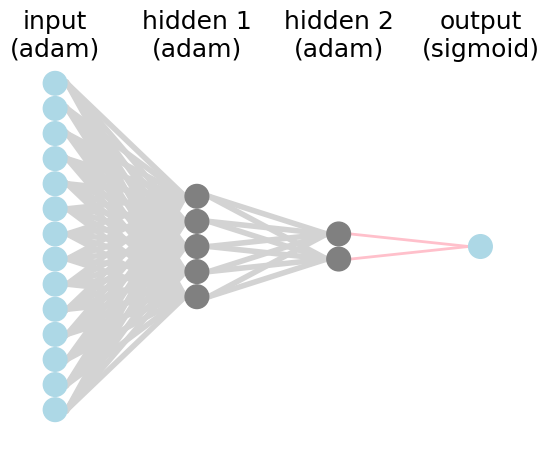

(<Figure size 2000x500 with 1 Axes>, <Axes: >)

In [156]:
# Draw neural network figure
plt.rcParams["figure.figsize"] = (20, 5)

layers_list = [    
    {"title":"input\n(adam)", "units": X_train.shape[1], "color": "lightblue"},    
    {"title":"hidden 1\n(adam)", "units": 5},    
    {"title":"hidden 2\n(adam)", "units": 2, "edges_color":"pink", "edges_width":2},    
    {"title":"output\n(sigmoid)", "units": 1,"color": "lightblue"},]

NNV(layers_list, max_num_nodes_visible=14, node_radius=8, spacing_layer=80).render()


In [121]:
# Create MLP model
regr = MLPRegressor(solver='lbfgs', alpha=0.0005, hidden_layer_sizes=(30, 20, 5), random_state=99, max_iter=800)

# Train MLP model on training set
regr.fit(X_train, y_train)

# Make predictions on the training and test sets
y_train_pred = regr.predict(X_train)
y_test_pred = regr.predict(X_test)

# Compute R2 score on the training and test sets
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Report performance
print('Training R2 score: {:.2f}'.format(r2_train))
print('Test R2 score: {:.2f}'.format(r2_test))

Training R2 score: 0.32
Test R2 score: 0.31


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [123]:
# Create MLP model
regr = MLPRegressor(solver='lbfgs', alpha=0.0005, hidden_layer_sizes=(30, 20, 5), random_state=99, max_iter=2000)

# Train MLP model on training set
regr.fit(X_train, y_train)

# Make predictions on the training and test sets
y_train_pred = regr.predict(X_train)
y_test_pred = regr.predict(X_test)

# Compute R2 score on the training and test sets
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Report performance
print('Training R2 score: {:.2f}'.format(r2_train))
print('Test R2 score: {:.2f}'.format(r2_test))

Training R2 score: 0.41
Test R2 score: 0.41


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


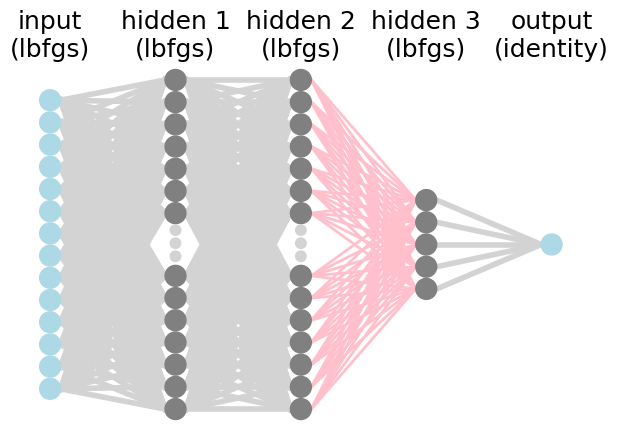

(<Figure size 2000x500 with 1 Axes>, <Axes: >)

In [129]:
plt.rcParams["figure.figsize"] = (20, 5)

layers_list = [    
    {"title":"input\n(lbfgs)", "units": 14, "color": "lightblue"},    
    {"title":"hidden 1\n(lbfgs)", "units": 30},    
    {"title":"hidden 2\n(lbfgs)", "units": 20, "edges_color":"pink", "edges_width":2}, 
    {"title":"hidden 3\n(lbfgs)", "units": 5},  
    {"title":"output\n(identity)", "units": 1,"color": "lightblue"},]

NNV(layers_list, max_num_nodes_visible=14, node_radius=8, spacing_layer=80).render()


Increasing max_iter in the lbfgs solver is positively impacting the R2 results of the model. However, it is also increasing the computational time. Hence, there is a trade off between time and model performance.